# List of todos/questions


- Custom regularization on non-driver features?
- Interaction terms?
- Finished (what if they didn't finish?) we still have placement for them
- Finishing position or relative finishing position?


- There's no way to validate the usefulness of this until we through it into the predictive model

In [687]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [528]:
def load_kaggle_data(path):
    data = pd.read_csv(path)
    data.replace({'\\N':np.nan}, inplace=True)
    return data

data_dir ='kaggle-data/'

circuits_raw_df = load_kaggle_data(f'{data_dir}/circuits.csv')
constructors_raw_df = load_kaggle_data(f'{data_dir}/constructors.csv')
constructor_standings_raw_df = load_kaggle_data(f'{data_dir}/constructor_standings.csv')
driver_standings_raw_df = load_kaggle_data(f'{data_dir}/driver_standings.csv')
drivers_raw_df = load_kaggle_data(f'{data_dir}/drivers.csv')
laptimes_raw_df = load_kaggle_data(f'{data_dir}/lap_times.csv')
pitstops_raw_df = load_kaggle_data(f'{data_dir}/pit_stops.csv')
qualifying_raw_df = load_kaggle_data(f'{data_dir}/qualifying.csv')
races_raw_df = load_kaggle_data(f'{data_dir}/races.csv')
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')
seasons_raw_df = load_kaggle_data(f'{data_dir}/seasons.csv')
sprint_results = load_kaggle_data(f'{data_dir}/sprint_results.csv')
status_raw_df = load_kaggle_data(f'{data_dir}/status.csv')

print('circuits_raw_df', circuits_raw_df.columns)
print('constructors_raw_df', constructors_raw_df.columns)
print('constructor_standings_raw_df', constructor_standings_raw_df.columns)
print('driver_standings_raw_df', driver_standings_raw_df.columns)
print('drivers_raw_df', drivers_raw_df.columns)
print('laptimes_raw_df', laptimes_raw_df.columns)
print('pitstops_raw_df', pitstops_raw_df.columns)
print('qualifying_raw_df', qualifying_raw_df.columns)
print('races_raw_df', races_raw_df.columns)
print('results_raw_df', results_raw_df.columns)
print('seasons_raw_df', seasons_raw_df.columns)
print('sprint_results', sprint_results.columns)
print('status_raw_df', status_raw_df.columns)

circuits_raw_df Index(['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng',
       'alt', 'url'],
      dtype='object')
constructors_raw_df Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url'], dtype='object')
constructor_standings_raw_df Index(['constructorStandingsId', 'raceId', 'constructorId', 'points',
       'position', 'positionText', 'wins'],
      dtype='object')
driver_standings_raw_df Index(['driverStandingsId', 'raceId', 'driverId', 'points', 'position',
       'positionText', 'wins'],
      dtype='object')
drivers_raw_df Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url'],
      dtype='object')
laptimes_raw_df Index(['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds'], dtype='object')
pitstops_raw_df Index(['raceId', 'driverId', 'stop', 'lap', 'time', 'duration',
       'milliseconds'],
      dtype='object')
qualifying_raw_df Index(['qualifyId', 'raceId', 'driverId',

In [529]:
drivers = drivers_raw_df[['driverId','forename','surname','number']].reset_index(drop=True)
drivers['Name'] = drivers[['forename', 'surname']].agg(' '.join, axis=1)
drivers.drop(['forename','surname'], axis=1, inplace=True)

driver_name_id_map = dict(zip(drivers['Name'], drivers['driverId']))
def get_driverID(name):
    
    return drivers.loc[drivers['Name']==name, 'driverId'].squeeze()

driver_name_number_map = dict(zip(drivers['Name'], drivers['number']))
def get_driver_number(name):
    
    return drivers.loc[drivers['Name']==name, 'number'].squeeze()


#drivers[drivers['Name'].str.contains('Nyck')]

driver_names_of_interest = ['Max Verstappen',
                           'Sergio Pérez',
                           'Lewis Hamilton',
                           'Fernando Alonso',
                           'Charles Leclerc',
                           'Lando Norris',
                           'George Russell',
                           'Oscar Piastri',
                           'Lance Stroll',
                           'Pierre Gasly',
                           'Esteban Ocon',
                           'Alexander Albon',
                           'Nico Hülkenberg',
                           'Valtteri Bottas',
                           'Guanyu Zhou',
                           'Yuki Tsunoda',
                           'Kevin Magnussen',
                           #'Liam Lawson',
                           'Logan Sargeant',
                           'Nyck de Vries',
                           'Daniel Ricciardo']
driver_ids_of_interest = [driver_name_id_map[name] for name in driver_names_of_interest]

driver_numbers_of_interest = [driver_name_number_map[name] for name in driver_names_of_interest]


In [544]:
# start with race results
# extend positionText labels (see Appendix)
results_raw_df['positionText'] = results_raw_df['positionText'].replace({'R':'Retired','D':'Disqualified','N':'not classified', 'E':'Excluded','W':'Withdrawn','F':'failed to qualify'})

# drop time, milliseconds, fastestLap, rank, fastestLapTime, fastestLapSpeed, and number (http://ergast.com/mrd/methods/results/)
races = results_raw_df.drop(['time','milliseconds','fastestLap','rank','fastestLapTime','fastestLapSpeed','number'], axis=1)
races.drop(['positionOrder'], axis=1, inplace=True)
races['position'].fillna('NaN', inplace=True)
#display(races.isna().sum())
assert races.isna().sum().sum() == 0, 'there are null values'

# Merge with drivers
prev_len = races.shape[0]
races = races.merge(drivers[['driverId','Name']], on='driverId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Name'].isna().sum() == 0


# Filter for drivers of interest
races = races[races['Name'].isin(driver_names_of_interest)].reset_index(drop=True)
assert races['driverId'].nunique() == len(driver_ids_of_interest), 'confirm we have lap data for all drivers of interest'
races.drop(['driverId'], axis=1, inplace=True)
assert races.groupby(['raceId','Name']).size().max() == 1, 'driver occurs twice in a race'

# Get status string
prev_len = races.shape[0]
races = races.merge(status_raw_df[['statusId','status']], on='statusId', how='left')
assert races['status'].isna().sum() == 0
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
races.drop(['statusId'], axis=1, inplace=True)


# Get car name
prev_len = races.shape[0]
constructors_raw_df.rename(columns={'name':'Car'}, inplace=True)
car_names = constructors_raw_df['Car'].unique()
races = races.merge(constructors_raw_df[['constructorId','Car']], on='constructorId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races['Car'].isna().sum() == 0
races.drop(['constructorId'], axis=1, inplace=True)

# Get race data (ignoring qualifying data)
races_raw_df.rename(columns={'name':'Race'}, inplace=True)
prev_len = races.shape[0]
races = races.merge(races_raw_df[['raceId','Race','round','circuitId','date']], on='raceId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0


# Get circuit data
prev_len = races.shape[0]
circuits_raw_df.rename(columns={'name':'Circuit'}, inplace=True)
circuits_raw_df['alt'].fillna(circuits_raw_df['alt'].median(), inplace=True) # impute median altitude -- #todo may want to change
races = races.merge(circuits_raw_df[['circuitId','Circuit','location','country','alt','lat','lng']], on='circuitId', how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0
races.drop(['circuitId'], axis=1, inplace=True)

# Explode date
races['date'] = pd.to_datetime(races['date'])
races['Month'] = races['date'].dt.month
races['Year'] = races['date'].dt.year
races.drop(['date'], axis=1, inplace=True)

# Get number of laps in the race
number_of_laps = results_raw_df[results_raw_df['statusId']==1].groupby(['raceId'])['laps'].max().reset_index(name='nlaps')
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
prev_len = races.shape[0]
races = races.merge(number_of_laps, on='raceId',how='left')
assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'
assert races.isna().sum().sum() == 0, 'there is at least one race where none of the drivers finished -- cannot find number of laps in the race'
races.drop(['laps'], axis=1, inplace=True)


races
races['Year'].min()

2001

In [689]:
# Handle position
races['position'] = races['position'].astype(float)

# Fill in missing position with last place

# race_n_drivers = results_raw_df.groupby('raceId')['driverId'].nunique().reset_index(name='total_drivers_race')
# prev_len = races.shape[0]
# races = races.merge(race_n_drivers, on='raceId', how='left')
# assert races.shape[0] == prev_len, 'confirm no duplicates formed during merge'

# races['position'].fillna(races['total_drivers_race'], inplace=True)
# races.drop('total_drivers_race', axis=1, inplace=True)

# Remove entries were driver did not finish/compete
races = races[races['position'].notnull()].reset_index(drop=True)

In [690]:
# remove races where there was only 1 driver of interest
prev_n_races = races['raceId'].nunique()
race_counts = races['raceId'].value_counts()
valid_races = race_counts[race_counts > 1].index
races = races[races['raceId'].isin(valid_races)].reset_index(drop=True)
print(prev_n_races - races['raceId'].nunique())

0


# EDA

In [240]:
races.groupby('Name')[['Car']].nunique().mean()

Car    2.95
dtype: float64

## Number of Laps Per Race

In [509]:
laps_per_race

,laps
raceId,
2,31
3,56
4,57
5,66
6,78
...,...
1106,70
1107,71
1108,52


In [523]:
races.groupby('raceId')[['laps']].min().reset_index()['laps']

,raceId,laps
0,2,31
1,3,56
2,4,57
3,5,65
4,6,77
...,...,...
306,1106,69
307,1107,70
308,1108,46
309,1109,69


In [534]:
races[races['laps']==1]

,resultId,raceId,grid,position,positionText,points,laps,Name,status,Car,Race,round,Circuit,location,country,alt,lat,lng,Month,Year
1675,25186,1063,1,1.0,1,12.5,1,Max Verstappen,Finished,Red Bull,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1676,25187,1063,2,2.0,2,9.0,1,George Russell,Finished,Williams,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1677,25188,1063,3,3.0,3,7.5,1,Lewis Hamilton,Finished,Mercedes,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1678,25189,1063,4,4.0,4,6.0,1,Daniel Ricciardo,Finished,McLaren,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1679,25191,1063,6,6.0,6,4.0,1,Pierre Gasly,Finished,AlphaTauri,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1680,25192,1063,8,7.0,7,3.0,1,Esteban Ocon,Finished,Alpine F1 Team,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1681,25193,1063,9,8.0,8,2.0,1,Charles Leclerc,Finished,Ferrari,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1682,25196,1063,12,11.0,11,0.0,1,Fernando Alonso,Finished,Alpine F1 Team,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1683,25197,1063,13,12.0,12,0.0,1,Valtteri Bottas,Finished,Mercedes,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021
1684,25199,1063,15,14.0,14,0.0,1,Lando Norris,Finished,McLaren,Belgian Grand Prix,12,Circuit de Spa-Francorchamps,Spa,Belgium,401,50.4372,5.97139,8,2021


In [522]:
races.groupby('raceId')[['laps']].max().reset_index()

,raceId,laps
0,2,31
1,3,56
2,4,57
3,5,66
4,6,78
...,...,...
306,1106,70
307,1107,71
308,1108,52
309,1109,70


In [525]:
assert sum(races.groupby('raceId')[['laps']].max().reset_index()['laps'] != races.groupby('raceId')[['laps']].min().reset_index()['laps']) == 0

AssertionError: 

<AxesSubplot:xlabel='nlaps', ylabel='Count'>

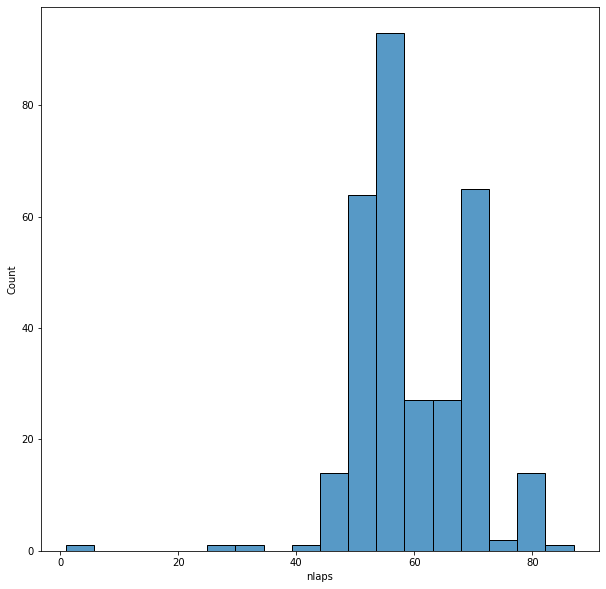

In [550]:
fig, ax = plt.subplots(figsize=(10,10))

laps_per_race = races.groupby('raceId')[['nlaps']].max().reset_index()
sns.histplot(data=laps_per_race, x='nlaps')

## Driver Placement IQR

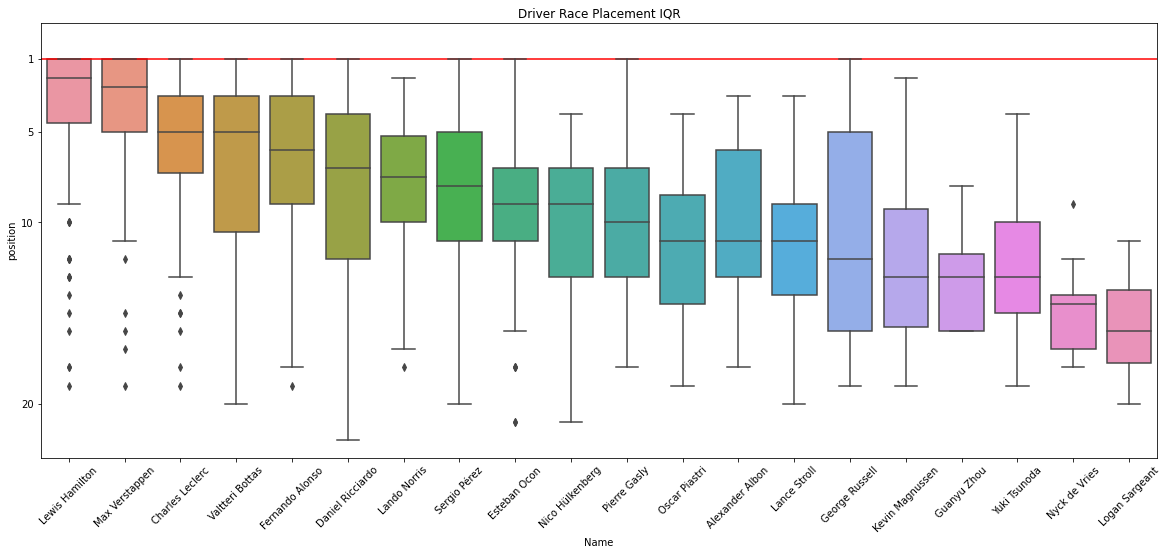

In [439]:
fig, ax = plt.subplots(figsize=(20, 8))
title = 'Driver Race Placement IQR'
plt.title(title)
plt.axhline(y=1, color='r', linestyle='-')

driver_median_positions = races.groupby('Name')['position'].median().sort_values().index
sns.boxplot(data=races, x='Name', y='position', order=driver_median_positions)
# tilt x axis labels
plt.xticks(rotation=45)
plt.yticks([1, 5, 10, 20, 25])
plt.ylim(23, -1)
plt.savefig(f'eda_visualizations/{title}.png')

## Driver Imbalance

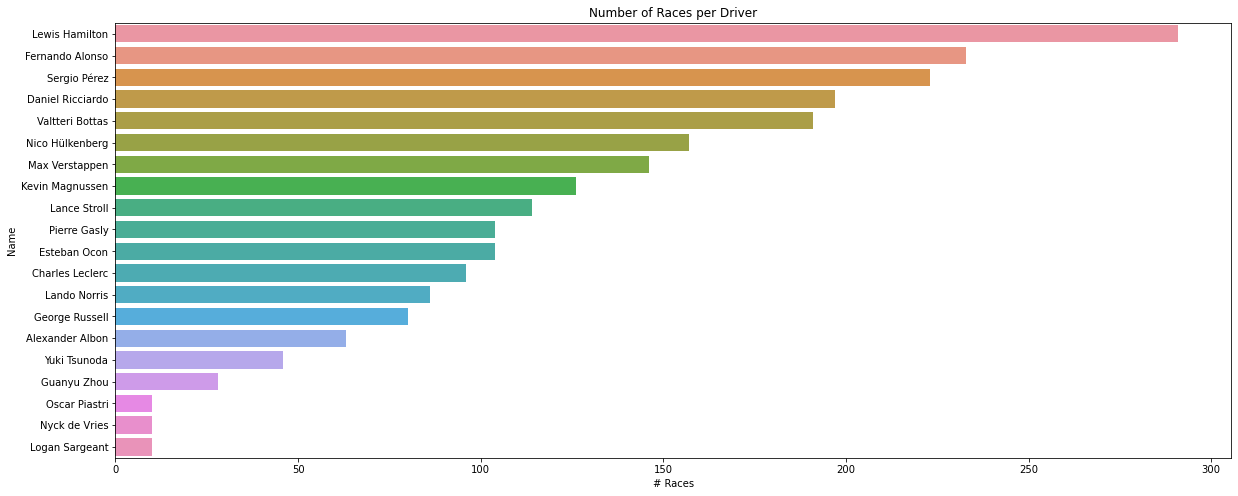

In [440]:
fig, ax = plt.subplots(figsize=(20, 8))
title = 'Number of Races per Driver'
plt.title(title)
driver_n_races = races.groupby('Name').size().sort_values(ascending=False).reset_index(name='# Races')

sns.barplot(data=driver_n_races, x='# Races', y='Name')

plt.savefig(f'eda_visualizations/{title}.png')

# Models

In [637]:
model_data = races.copy(deep=True)
X, y = model_data.drop(['position'], axis=1), model_data['position']

X.drop(['raceId','resultId','positionText','points','status','lat','lng','location','country','Race','Circuit'], axis=1, inplace=True)
X

,grid,Name,Car,round,alt,Month,Year,nlaps
0,1,Lewis Hamilton,McLaren,1,10,3,2008,58
1,11,Fernando Alonso,Renault,1,10,3,2008,58
2,9,Lewis Hamilton,McLaren,2,18,3,2008,56
3,7,Fernando Alonso,Renault,2,18,3,2008,56
4,10,Fernando Alonso,Renault,3,7,4,2008,57
...,...,...,...,...,...,...,...,...
2310,15,Alexander Albon,Williams,12,401,7,2023,44
2311,16,Kevin Magnussen,Haas F1 Team,12,401,7,2023,44
2312,19,Daniel Ricciardo,AlphaTauri,12,401,7,2023,44
2313,18,Logan Sargeant,Williams,12,401,7,2023,44


## Trivial Model (just driver)

In [638]:
def driver_only(data, y):
    data = data['Name']
    data = pd.get_dummies(data, columns=['Name'], drop_first=False,prefix='')
    X = data.values

    y = (y == 1).astype(int)

    logreg = LogisticRegression(max_iter=1000, penalty='none', fit_intercept=False)
    logreg.fit(X, y)

    # get coefficients
    coef = logreg.coef_

    weights = pd.DataFrame(coef, columns=data.columns)

    
    return weights

coef = driver_only(X, y)



In [639]:
coef

,_Alexander Albon,_Charles Leclerc,_Daniel Ricciardo,_Esteban Ocon,_Fernando Alonso,_George Russell,_Guanyu Zhou,_Kevin Magnussen,_Lance Stroll,_Lando Norris,_Lewis Hamilton,_Logan Sargeant,_Max Verstappen,_Nico Hülkenberg,_Nyck de Vries,_Oscar Piastri,_Pierre Gasly,_Sergio Pérez,_Valtteri Bottas,_Yuki Tsunoda
0,-19.567793,-2.901489,-3.162381,-4.635063,-2.542068,-4.36992,-18.69041,-21.175544,-20.810103,-20.084024,-0.631885,-17.624256,-0.808457,-22.306595,-17.624256,-17.624256,-4.635063,-3.588293,-2.895961,-19.176121


In [640]:
def driver_only_linear(data, y):
    data = data['Name']
    data = pd.get_dummies(data, columns=['Name'], drop_first=False)
    X = data.values

    #y = (y == 1).astype(int)

    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    #return coef
    weights = pd.DataFrame([coef], columns=data.columns)


    return weights

baseline_coef = driver_only_linear(X, y)
baseline_coef

,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,Kevin Magnussen,Lance Stroll,Lando Norris,Lewis Hamilton,Logan Sargeant,Max Verstappen,Nico Hülkenberg,Nyck de Vries,Oscar Piastri,Pierre Gasly,Sergio Pérez,Valtteri Bottas,Yuki Tsunoda
0,10.079365,6.010417,8.324873,9.375,6.656652,10.575,13.107143,12.365079,11.122807,8.139535,3.446735,15.9,3.787671,9.910828,14.8,11.2,9.894231,8.130045,6.732984,12.478261


In [641]:
def model2(data, y):
    data = data[['Name','grid','Car','alt','Month','Year','nlaps']]
    data = data[['Name','grid','alt','nlaps']]
    data = pd.get_dummies(data, columns=['Name'], drop_first=False, prefix='', prefix_sep='')
    #data = pd.get_dummies(data, columns=['Car'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Month'], drop_first=False)
    #data = pd.get_dummies(data, columns=['Year'], drop_first=False)
    mm = MinMaxScaler()
    data[['grid','alt','nlaps']] = mm.fit_transform(data[['grid','alt','nlaps']])
    display(data)
    X = data.values

    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)

    # get coefficients
    coef = linreg.coef_
    #return coef
    weights = pd.DataFrame([coef], columns=data.columns)


    return weights

coef = model2(X, y)
coef

,grid,alt,nlaps,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,...,Lewis Hamilton,Logan Sargeant,Max Verstappen,Nico Hülkenberg,Nyck de Vries,Oscar Piastri,Pierre Gasly,Sergio Pérez,Valtteri Bottas,Yuki Tsunoda
0,0.041667,0.007610,0.662791,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.458333,0.007610,0.662791,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.375000,0.011191,0.639535,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0.291667,0.011191,0.639535,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.416667,0.006267,0.651163,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,0.625000,0.182632,0.500000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2311,0.666667,0.182632,0.500000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2312,0.791667,0.182632,0.500000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313,0.750000,0.182632,0.500000,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


,grid,alt,nlaps,Alexander Albon,Charles Leclerc,Daniel Ricciardo,Esteban Ocon,Fernando Alonso,George Russell,Guanyu Zhou,...,Lewis Hamilton,Logan Sargeant,Max Verstappen,Nico Hülkenberg,Nyck de Vries,Oscar Piastri,Pierre Gasly,Sergio Pérez,Valtteri Bottas,Yuki Tsunoda
0,10.537935,0.176569,0.006554,5.245542,3.038626,4.096786,4.599312,2.998979,5.566034,6.997814,...,1.706806,8.243194,1.466201,5.476202,8.813218,6.74922,5.311511,3.912027,3.736803,7.055785


In [693]:
def plot_driver_weight_change(weights1, weights2, model1name=None, model2name=None, save=False):
    weights1 = baseline_coef
    weights2 = coef
    weights1 = weights1[[c for c in weights1.columns if c in driver_names_of_interest]].copy()
    #weights1.rename(index={0:'baseline'}, inplace=True)
    weights2 = weights2[[c for c in weights2.columns if c in driver_names_of_interest]].copy()
    #weights2.rename(index={0:'baseline'}, inplace=True)

    assert len(weights1) == len(weights2)

    weights1 = weights1.T.reset_index()
    weights1.columns = ['Driver','Model1']
    weights1['Model1'] = weights1['Model1'] / weights1['Model1'].sum()

    weights2 = weights2.T.reset_index()
    weights2.columns = ['Driver','Model2']
    weights2['Model2'] = weights2['Model2'] / weights2['Model2'].sum()


    weights = weights1.merge(weights2, on='Driver')
    #print(weights)

    fig, ax = plt.subplots(figsize=(20, 8))
    title = 'Driver Weights'
    plt.title(title)
    plt.xlabel('Model 1')
    plt.ylabel('Model 2')
    xmin = weights1['Model1'].min()
    xmax = weights1['Model1'].max()
    x = np.linspace(xmin, xmax,100)
    y = x
    plt.xlim(xmin-0.02, xmax+0.02)
    plt.ylim(xmin-0.02, xmax+0.02)

    plt.plot(x, y, 'blue', label='y=2x+1')

    weights = weights.sort_values(by='Model1', ascending=False)

    for row in range(0,weights.shape[0]):
        sub = weights.iloc[row:row+1].melt(id_vars=['Driver'])
        #print(sub)
        weight_increased = sub[sub['variable']=='Model1']['value'].squeeze() > sub[sub['variable']=='Model2']['value'].squeeze()
        marker_dict = {True: 'v', False: '^'}
        sub = sub[sub['variable'].isin(['Model1', 'Model2'])]
        sub['Model1'] = sub[sub['variable']=='Model1']['value'].squeeze()
        color_dict = {True:'green', False:'red'}
        lp = sns.lineplot(data=sub, x='Model1', y='value', color= color_dict[weight_increased],linewidth = 3, estimator=None) # hue_order=['preds_no_age','preds_age'], palette=['#99ADE9', '#EFCB99'])
        sp = sns.scatterplot(data=sub, x='Model1', y='value',marker=marker_dict[weight_increased], s=100, color=color_dict[weight_increased]) #, hue='variable',hue_order=['Parent SNAP Baseline','Parent SNAP Endpoint'], palette=['#ECA985','#D25613'], marker=marker_dict[decreased])
        
        #print(sub.loc[0,'value'].squeeze())
        start_x = sub.loc[0,'value'].squeeze()
        start_y = (sub.loc[0,'value'].squeeze() + sub.loc[1,'value'].squeeze())/2

        #end_y = start_y + 0.01 if row % 2 == 0 else start_y - 0.01
        end_y = start_y - 0.01 if weight_increased else start_y + 0.01

        plt.annotate(sub['Driver'].values[0], (start_x, start_y), xytext=(start_x, end_y),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', fc=color_dict[weight_increased]))
        plt.legend([],[], frameon=False)

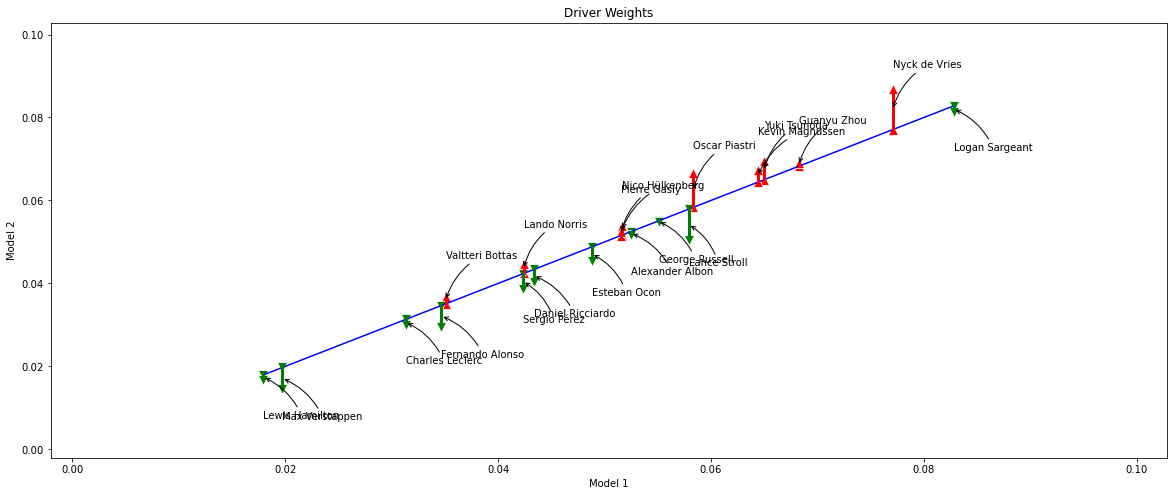

In [694]:
plot_driver_weight_change(baseline_coef, coef)

# Appendix

## results_raw_df

In [59]:
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')
# position and position order are the same
assert sum(results_raw_df['position'] == results_raw_df['positionOrder']) == 0

print(results_raw_df.loc[results_raw_df['position'] != results_raw_df['positionText'], 'position'].unique())
print(results_raw_df.loc[results_raw_df['position'] != results_raw_df['positionText'], 'positionText'].unique())

[nan]
['R' 'D' 'N' '11' '14' 'W' 'F' 'E']


## Race data has missing values for time

In [49]:
kaggle_race_data = load_kaggle_data(f'{data_dir}/races.csv')
assert kaggle_race_data.shape[0] == kaggle_race_data['raceId'].nunique(), 'confirm no duplicates'
kaggle_race_data.rename(columns={'name':'Race'}, inplace=True)
kaggle_race_data = kaggle_race_data[['raceId','Race','year','round','circuitId','date','time']]
kaggle_race_data.isna().sum()

raceId         0
Race           0
year           0
round          0
circuitId      0
date           0
time         731
dtype: int64

## Use driverId not number

In [171]:
races_raw_df = load_kaggle_data(f'{data_dir}/races.csv')
results_raw_df = load_kaggle_data(f'{data_dir}/results.csv')

raceiddriver = races_raw_df[['raceId','year']].merge(results_raw_df[['raceId','number','driverId']], on='raceId', how='left')
#raceiddriver = races_raw_df[races_raw_df['year']==races_raw_df['year'].min()][['raceId','year']].merge(results_raw_df[['raceId','number','driverId']], on='raceId', how='left')
#raceiddriver = raceiddriver[raceiddriver['raceId']==833].reset_index(drop=True)
raceiddriver = raceiddriver.merge(drivers[['driverId','number','Name']], on='number', how='left')
#raceiddriver['Name'].nunique()
raceiddriver.sort_values(by='Name')

assert raceiddriver.groupby(['Name'])['driverId_y'].nunique().max() == 1 # driverID is unique to driver name
#raceiddriver.groupby(['Name'])['driverId_y'].nunique()
